# Regression (polynomial) - Salary Data

In [187]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from summarytools import dfSummary
%matplotlib inline

In [101]:
try:
    df = pd.read_csv("Salaries.csv")
except IOError:
    "Data import failed!"

df.head(10)

,Position,Level,Salary
0,Business Analyst,1,45000
1,Junior Consultant,2,50000
2,Senior Consultant,3,60000
3,Region Manager,6,150000
4,Manager,4,80000
5,Partner,7,200000
6,Country Manager,5,110000
7,C-level,9,500000
8,Senior Partner,8,300000
9,CEO,10,1000000


In [23]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Position[object],1. Business Analyst2. Senior Consultant3. Partner4. Junior Consultant5. Country Manager6. CEO7. Region Manager8. Manager9. C-level10. Senior Partner,44 (47.8%)13 (14.1%)10 (10.9%)8 (8.7%)7 (7.6%)6 (6.5%)1 (1.1%)1 (1.1%)1 (1.1%)1 (1.1%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAADnCAYAAAAJgSQ2AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD20lEQVR4nO3dUWobVwCG0Stj0vpFwhi8DC8gi+hiuwgtwPswxvNQp3lRHxpKE0KjGUnf2Ok5KxjCxxUz3N/ZHA6HAYWrtR+A/w+xkREbGbGRERsZsZERGxmxkREbmc0Y42aM8WHtB3kHPh8Oh9e1H+I9u767u/ttu93erv0gb900Tc+bzeZ3wS13vd1ubz9+/Pi62+0+rf0wb9XLy8uv+/3+9unp6cMYQ2wLXY8xxm63+3R/f//H2g/zxt2s/QDvnRcEMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2Mtdj/H2FZu0Hecv8+5zH9TRNz/v9/na4QvOfpml6HmN8Xvs53jPXwo/nWviJNv6KEZVLnmxOAr5yscGLgQjfusjgxUCE77nk4MXbLV/xUZeM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MRQYvBiJ8z8UGLwYifMu1cDIGL2TOdbI5xfihswxejFs4xsmDF+MWjnWuwYtxCz/koy4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZE5eV1lScWxzrKusqTiGDYIZKyryCw92ZxkzLZoXWVNxRKz11XWVCy1dF1lTcVsPuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRmT14MXBhqUWDFwMXlnAtnIzBC5klJ5tTjUVmD16MXVhq1uDF2IVTLBm8GLuwiI+6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZGYNXoxdOMXswYuxC0u5Fk7G4IWMFwQyc35G/XxykqPXVVZVnOqodZVVFecwZ11lVcVJvCCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGROWpdZVXFORy9rrKq4lSuhZOxriLz75PNycVF/TN4MWjh0q622+3tw8PD+LKwmvtfQcLRrsYY4+bm5s+1H4Sfn4+6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZK7GGOP19fWXtR+En9/VNE3Pj4+PBi1cnGvhZAxeyHhBIONnlIx1FRnrKjLWVWS8IJARGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZGxriJjXUXGtXAy1lVknGxkDF7IGLyQMXgh46MuGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGYMXMgYvZFwLJ2PwQsbJRsbghYzBCxmDFzI+6pIRGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxnrKjLWVWRsEMhYV5HxgkBGbGTERkZsZMRGRmxkxEbmL93Q3Pgd1s3LAAAAAElFTkSuQmCC"">",0(0.0%)
2,Level[int64],Mean (sd) : 3.2 (2.8)min < med < max:1.0 < 2.0 < 10.0IQR (CV) : 4.0 (1.1),10 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACmklEQVR4nO3du47aQBSA4TOwIHORbYQCHU0KF5FSUPIQedg8QgqegJYiorO4yAhnHYxxiijRSpEAe/DiQ/6vXnu84hfD0RQ2eZ4LUHeNRz8AcIuXa39gjOmISLvk/Y95nr+WvBb462KoxpjOcDj84rruoMzN9/v9zhjzlVhh69o3att13cFsNnv1PC8pcuMoipz5fD7YbDZtESFUWLm69YuIeJ6XjEajHyXu3ylxDfAPhimoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKHCTe9CfRRewY4/ahsqr2DHW7UNVXgFO96oc6giwivY8RvDFFSo/Tfq/8ZygBR50iGSUGvEdoAUed4hklDrpfQAKfLcQ2SloWZZ1hIR1xhT5nL3fD637vxIKlgMkCJPOkRWFmocx600TT9PJpNms9ks/O2QpqmTZdmnJEm+iUjZD600DhvqpbJQj8fji+M43el0mozH413R61er1WCxWHRPp1Oziue7hMOG+qn8N2qv1yu1je12u0duYRw2lFDlLsQwdQGHDberehciVNxLpbsQoeKuqtqFOEKFCoQKFQgVKjztb9RHnopZrG19Gmf5fzdE5Fxy6UpPEp8y1EeeitmsbXsaZ7N2lmWtOI4/9vv9ZaPRSIuuXfVJ4k2hRlHkFL3x4XBwRETiOHbCMOy+5/Xb7bbvOE43CALj+/7Pomuv12tnuVx2oyjqhWF4fK+1bda909ofgiD47vv+oejaNs9+S1+/AJTDYNUaR4SrAAAAAElFTkSuQmCC"">",0(0.0%)
3,Salary[int64],Mean (sd) : 136786.5 (229168.3)min < med < max:34000.0 < 50000.0 < 1230000.0IQR (CV) : 48852.5 (0.6),60 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACYklEQVR4nO3YMW/aQBiH8feFgExCzwIqZ8vSvQMje9d82KwdI/EtuiMkK7GFYwQCd+tSKcTnkPBvn9/M3Rnr0Vl33jSNAZeu99kPALzF1akfuPvIzIaR8++apqkjxwJ/vBqqu49ms9l9CGESM3lZlk/u/kCs6OrUjjoMIUwWi0Wdpum2zcRFUSTL5XKS5/nQzAgVnZz89JuZpWm6zbLsJWL+UcQY4C8cpiCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCHh6pyTHw6HgZkFd4+dYtc0Tf2OjwRRZwu1qqrBfr//fnd31+/3+9uYOcqyfHL3B2LF2ULd7XZXSZJcz+fz7e3t7VPb8UVRJM

Text(0.5, 1.0, 'Salary per Position Level')

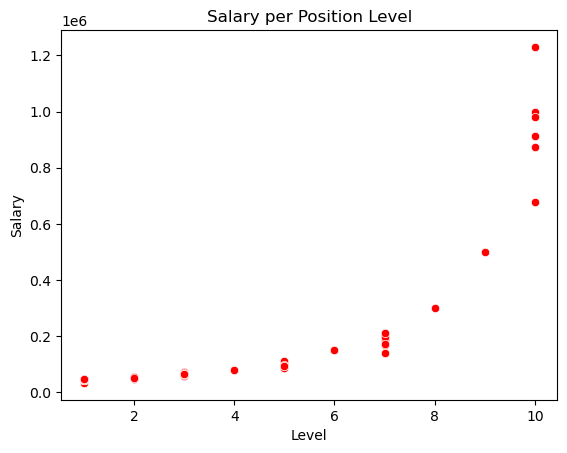

In [41]:
# Visualize data

sns.scatterplot(df, x="Level", y="Salary", color="red")
plt.title("Salary per Position Level")

In [59]:
# Check for Level-Position consistency

df2 = df.groupby(["Level","Position"]).nunique().sort_values("Level")
df2

,,Salary
Level,Position,
1,Business Analyst,17
2,Junior Consultant,6
3,Senior Consultant,11
4,Manager,1
5,Country Manager,7
6,Region Manager,1
7,Partner,9
8,Senior Partner,1
9,C-level,1


In [111]:
# Check for NA
print(df[df.isnull().any(axis=1)])

Empty DataFrame
Columns: [Position, Level, Salary]
Index: []


In [163]:
# Check for duplicates
df["duplicatedRow"] = df.duplicated(keep=False)
df[df["duplicatedRow"] == True].sort_values("Salary")

,Position,Level,Salary,duplicatedRow
0,Business Analyst,1,45000,True
32,Business Analyst,1,45000,True
69,Business Analyst,1,45600,True
63,Business Analyst,1,45600,True
58,Business Analyst,1,45600,True
53,Business Analyst,1,45600,True
48,Business Analyst,1,45600,True
38,Business Analyst,1,45600,True
43,Business Analyst,1,45600,True
68,Business Analyst,1,46000,True


In [165]:
# Eliminate duplicates due to overfitting/overweighting of individual values
df = df.drop("duplicatedRow", axis=1)
df = df.drop_duplicates(keep="first")

<Axes: ylabel='Salary'>

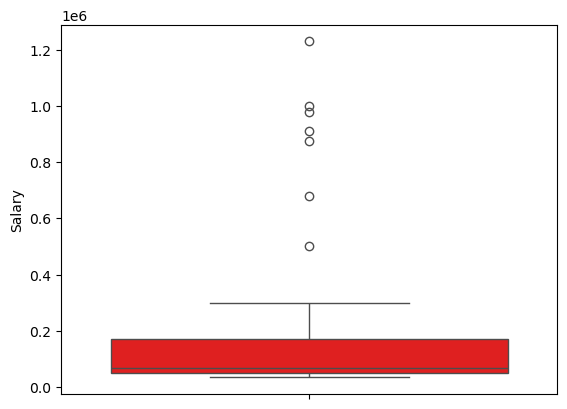

In [199]:
# Check for outliers

sns.boxplot(df["Salary"], color="red")

In [191]:
# Calculate basic statistical data

print(f'Mode Salary: {statistics.mode(df["Salary"])}')
print(f'Median Salary: {statistics.median(df["Salary"])}')
print(f'Average Salary: {statistics.mean(df["Salary"])}')
print(f'Standard deviation Salary: {round(statistics.stdev(df["Salary"]),2)}')
print(f'Correlation Salary-Level: {round(statistics.correlation(df["Salary"], df["Level"]),2)}')

Mode Salary: 45000
Median Salary: 68264.5
Average Salary: 181311.35
Standard deviation Salary: 273429.54
Correlation Salary-Level: 0.8


In [119]:
# Defining Kfold Cross validation method for polynomial features, using the LinearRegression model for regression method behind the PolynomialFeature transformation

def kfold_cross_validation_polynomials(X, y, degrees, k):
    X = np.array(X)
    y = np.array(y)
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    ms_errors = {degree: [] for degree in degrees}
    ms_sum_errors = {degree: [] for degree in degrees}

    for degree in degrees:
        poly_feature = PolynomialFeatures(degree=degree)
        for train_i, test_i in kfold.split(X):
            X_train, X_test = X[train_i], X[test_i]
            y_train, y_test = y[train_i], y[test_i]
            
            X_train_pf = poly_feature.fit_transform(X_train)
            X_test_pf = poly_feature.transform(X_test)
            
            lin_model = LinearRegression()
            lin_model.fit(X_train_pf, y_train)
            y_predict = lin_model.predict(X_test_pf)
            
            ms_error = mean_squared_error(y_test, y_predict)
            ms_errors[degree].append(ms_error)

        ms_sum_error = sum(ms_errors[degree])
        ms_sum_errors[degree].append(ms_sum_error)

    return ms_sum_errors

In [277]:
# Identify best polynomial grade for dataset
X = np.array(df["Level"]).reshape(-1,1)
y = np.array(df["Salary"]).reshape(-1,1)

polygrades = [1,2,3,4,5,6,7]

kfold_errors = kfold_cross_validation_polynomials(X,y,polygrades,10)
df_errors = pd.DataFrame.from_dict(kfold_errors, orient="index", columns=["Error"]).reset_index().rename(columns={"index": "Grade"})
df_errors["Error"] = df_errors["Error"].apply(lambda x: round(x/1000000000,2))
df_errors

,Grade,Error
0,1,282.13
1,2,81.38
2,3,45.22
3,4,41.05
4,5,40.40
5,6,40.26
6,7,41.34


In [491]:
# Fit and Visualize Polynoms
df_polynom_models = pd.DataFrame(columns=["Grade", "Model_name", "Polynom"])

for i in range(0, len(polygrades)):
    df_polynom_models.loc[i,"Grade"] = polygrades[i]
    df_polynom_models.loc[i,"Model_name"] = "Polynom Grade "+ str(polygrades[i])
    df_polynom_models.loc[i,"Polynom"] = np.poly1d(np.polyfit(np.squeeze(X).tolist(),np.squeeze(y).tolist(),polygrades[i]))

df_polynom_models

,Grade,Model_name,Polynom
0,1,Polynom Grade 1,[72425.08883777315]
1,2,Polynom Grade 2,"[18337.80025295277, -114030.39911544955]"
2,3,Polynom Grade 3,"[3230.154345826369, -33490.1494290769, 109108...."
3,4,Polynom Grade 4,"[556.9766866159947, -8506.040285207633, 46754...."
4,5,Polynom Grade 5,"[85.72406782529848, -1700.3491405660827, 13091..."
5,6,Polynom Grade 6,"[10.809251886976481, -265.0251273624123, 2724...."
6,7,Polynom Grade 7,"[-0.10879274995703322, 14.8519702126268, -325...."


Text(0.5, 1.0, 'Polynom Grade 7')

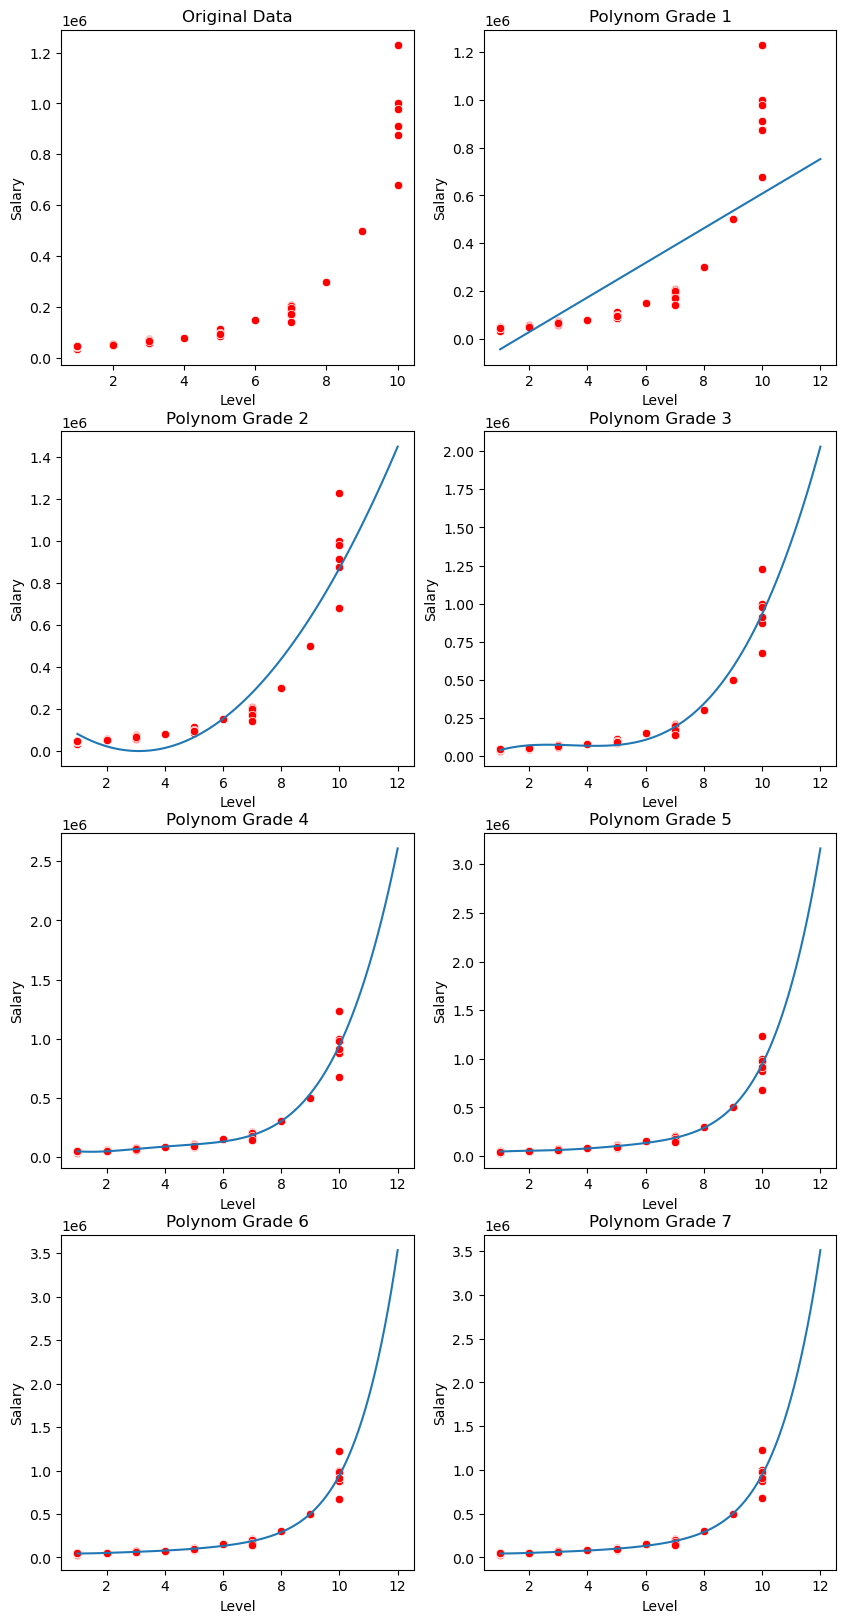

In [497]:
myline = np.linspace(1,12,100)

fig, axes = plt.subplots(4,2, figsize=(10,20))

p0 = sns.scatterplot(df, x="Level", y="Salary", color="red",  ax=axes[0,0])
axes[0,0].set_title("Original Data")

sns.lineplot(x=myline, y=df_polynom_models.loc[0,"Polynom"](myline), ax=axes[0,1])
sns.scatterplot(df, x="Level", y="Salary", color="red",  ax=axes[0,1])
axes[0,1].set_title(df_polynom_models.loc[0,"Model_name"])

sns.lineplot(x=myline, y=df_polynom_models.loc[1,"Polynom"](myline), ax=axes[1,0])
sns.scatterplot(df, x="Level", y="Salary", color="red",  ax=axes[1,0])
axes[1,0].set_title(df_polynom_models.loc[1,"Model_name"])

sns.lineplot(x=myline, y=df_polynom_models.loc[2,"Polynom"](myline), ax=axes[1,1])
sns.scatterplot(df, x="Level", y="Salary", color="red",  ax=axes[1,1])
axes[1,1].set_title(df_polynom_models.loc[2,"Model_name"])

sns.lineplot(x=myline, y=df_polynom_models.loc[3,"Polynom"](myline), ax=axes[2,0])
sns.scatterplot(df, x="Level", y="Salary", color="red",  ax=axes[2,0])
axes[2,0].set_title(df_polynom_models.loc[3,"Model_name"])

sns.lineplot(x=myline, y=df_polynom_models.loc[4,"Polynom"](myline), ax=axes[2,1])
sns.scatterplot(df, x="Level", y="Salary", color="red",  ax=axes[2,1])
axes[2,1].set_title(df_polynom_models.loc[4,"Model_name"])

sns.lineplot(x=myline, y=df_polynom_models.loc[5,"Polynom"](myline), ax=axes[3,0])
sns.scatterplot(df, x="Level", y="Salary", color="red",  ax=axes[3,0])
axes[3,0].set_title(df_polynom_models.loc[5,"Model_name"])

sns.lineplot(x=myline, y=df_polynom_models.loc[6,"Polynom"](myline), ax=axes[3,1])
sns.scatterplot(df, x="Level", y="Salary", color="red",  ax=axes[3,1])
axes[3,1].set_title(df_polynom_models.loc[6,"Model_name"])